# The Matplotlib Jupyter Widget Backend

Enabling interaction with matplotlib charts in the Jupyter notebook and JupyterLab

https://github.com/matplotlib/ipympl

In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

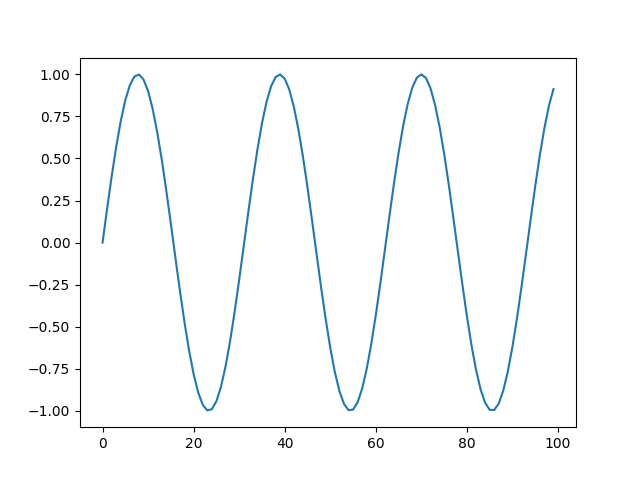

In [2]:
# Testing matplotlib interactions with a simple plot
fig = plt.figure()
plt.plot(np.sin(np.linspace(0, 20, 100)));

In [ ]:
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False # Hide the Figure name at the top of the figure

In [ ]:
fig.canvas.footer_visible = False

In [ ]:
fig.canvas.resizable = False

In [ ]:
# If true then scrolling while the mouse is over the canvas will not move the entire notebook
fig.canvas.capture_scroll = True

You can also call `display` on `fig.canvas` to display the interactive plot anywhere in the notebooke

In [3]:
fig.canvas.toolbar_visible = True
display(fig.canvas)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Or you can `display(fig)` to embed the current plot as a png

In [ ]:
display(fig)

# 3D plotting

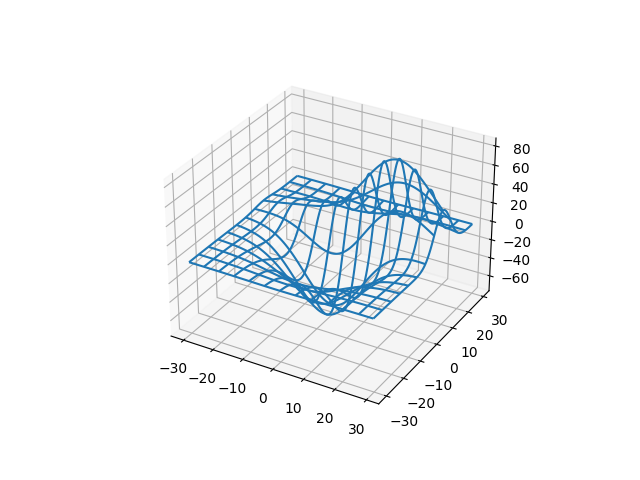

In [3]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

# Subplots

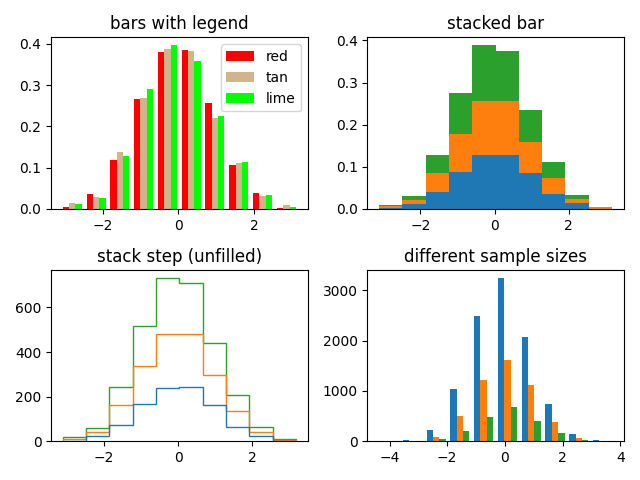

In [4]:
# A more complex example from the matplotlib gallery
np.random.seed(0)

n_bins = 10
x = np.random.randn(1000, 3)

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=1, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=1, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()

In [ ]:
fig.canvas.toolbar_position = 'right'

In [ ]:
fig.canvas.toolbar_visible = False

# Interactions with other widgets and layouting

When you want to embed the figure into a layout of other widgets you should call `plt.ioff()` before creating the figure otherwise `plt.figure()` will trigger a display of the canvas automatically and outside of your layout. 

### Without using `ioff`

Here we will end up with the figure being displayed twice. The button won't do anything it just placed as an example of layouting.

In [ ]:
import ipywidgets as widgets

# ensure we are interactive mode 
# this is default but if this notebook is executed out of order it may have been turned off
plt.ion()

fig = plt.figure()
ax = fig.gca()
ax.imshow(Z)

widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.Button(icon='check'),
    pane_heights=[0, 6, 1]
)

### Fixing the double display with `ioff`

If we make sure interactive mode is off when we create the figure then the figure will only display where we want it to.

There is ongoing work to allow usage of `ioff` as a context manager, see the [ipympl issue](https://github.com/matplotlib/ipympl/issues/220) and the [matplotlib issue](https://github.com/matplotlib/matplotlib/issues/17013)

In [ ]:
plt.ioff()
fig = plt.figure()
plt.ion()

ax = fig.gca()
ax.imshow(Z)

widgets.AppLayout(
    center=fig.canvas,
    footer=widgets.Button(icon='check'),
    pane_heights=[0, 6, 1]
)

# Interacting with other widgets

## Changing a line plot with a slide

In [ ]:
# When using the `widget` backend from ipympl,
# fig.canvas is a proper Jupyter interactive widget, which can be embedded in
# an ipywidgets layout. See https://ipywidgets.readthedocs.io/en/stable/examples/Layout%20Templates.html

# One can bound figure attributes to other widget values.
from ipywidgets import AppLayout, FloatSlider

plt.ioff()

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=1.0,
    min=0.02,
    max=2.0
)

slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

fig = plt.figure()
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
plt.title('Plotting: y=sin({} * x)'.format(slider.value))

x = np.linspace(0, 20, 500)

lines = plt.plot(x, np.sin(slider.value * x))

def update_lines(change):
    plt.title('Plotting: y=sin({} * x)'.format(change.new))
    lines[0].set_data(x, np.sin(change.new * x))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_lines, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

## Update image data in a performant manner

Two useful tricks to improve performance when updating an image displayed with matplolib are to:
1. Use the `set_data` method instead of calling imshow
2. Precompute and then index the array

In [ ]:
# precomputing all images
x = np.linspace(0,np.pi,200)
y = np.linspace(0,10,200)
X,Y = np.meshgrid(x,y)
parameter = np.linspace(-5,5)
example_image_stack = np.sin(X)[None,:,:]+np.exp(np.cos(Y[None,:,:]*parameter[:,None,None]))

In [ ]:
plt.ioff()
fig = plt.figure()
plt.ion()
im = plt.imshow(example_image_stack[0])

def update(change):
    im.set_data(example_image_stack[change['new']])
    fig.canvas.draw_idle()
    
    
slider = widgets.IntSlider(value=0, min=0, max=len(parameter)-1)
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

### Debugging widget updates and matplotlib callbacks

If an error is raised in the `update` function then will not always display in the notebook which can make debugging difficult. This same issue is also true for matplotlib callbacks on user events such as mousemovement, for example see [issue](https://github.com/matplotlib/ipympl/issues/116). There are two ways to see the output:
1. In jupyterlab the output will show up in the Log Console (View > Show Log Console)
2. using `ipywidgets.Output`

Here is an example of using an `Output` to capture errors in the update function from the previous example. To induce errors we changed the slider limits so that out of bounds errors will occur:

From: `slider = widgets.IntSlider(value=0, min=0, max=len(parameter)-1)`

To:   `slider = widgets.IntSlider(value=0, min=0, max=len(parameter)+10)`

If you move the slider all the way to the right you should see errors from the Output widget

In [ ]:
plt.ioff()
fig = plt.figure()
plt.ion()
im = plt.imshow(example_image_stack[0])

out = widgets.Output()
@out.capture()
def update(change):
    with out:
        if change['name'] == 'value':
            im.set_data(example_image_stack[change['new']])
            fig.canvas.draw_idle
    
    
slider = widgets.IntSlider(value=0, min=0, max=len(parameter)+10)
slider.observe(update)
display(widgets.VBox([slider, fig.canvas]))
display(out)